In [1]:
%matplotlib inline
import softmax_chains_planning_and_learning

In [2]:
CONFIG = {
    'SEED': None,
    
    'N_CHAINS': 9,
    'CHAIN_LENGTH': 4,
    'GAIN': 10,
    'LINGERING_INPUT_VALUE': 1,
    'WEAK_CXN_IDXS': (1, 2),
    'WEAK_CXN_WEIGHT': 1,
    
    'DRIVE_MULTI_BY_COORDINATE': [
            [([(0, 0), 2],),
             ([(0, 1), 1.], [(1, 2), 1.5], [(1, 3), 1.5]),
             ([(0, 1), 1.], [(1, 2), 1.5], [(1, 3), 1.5]),
             ([(0, 1), 1.], [(1, 2), 1.5], [(1, 3), 1.5])]
            for _ in range(6)
        ],

    'N_TRIALS': 6,
    
    'FIG_SIZE': (15, 8),
    'COLORS': [
            (0, 0, 0),(1, 0, 0), (0, 1, 0), (0, 0, 1), (0, 1, 1),
            (1, 0, 1), (.5, .5, 0), (.5, .5, .5), (.5, 0, 0)
        ],
    'LW': 2,
    'FONT_SIZE': 16,
}

/Users/rkp/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1644: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


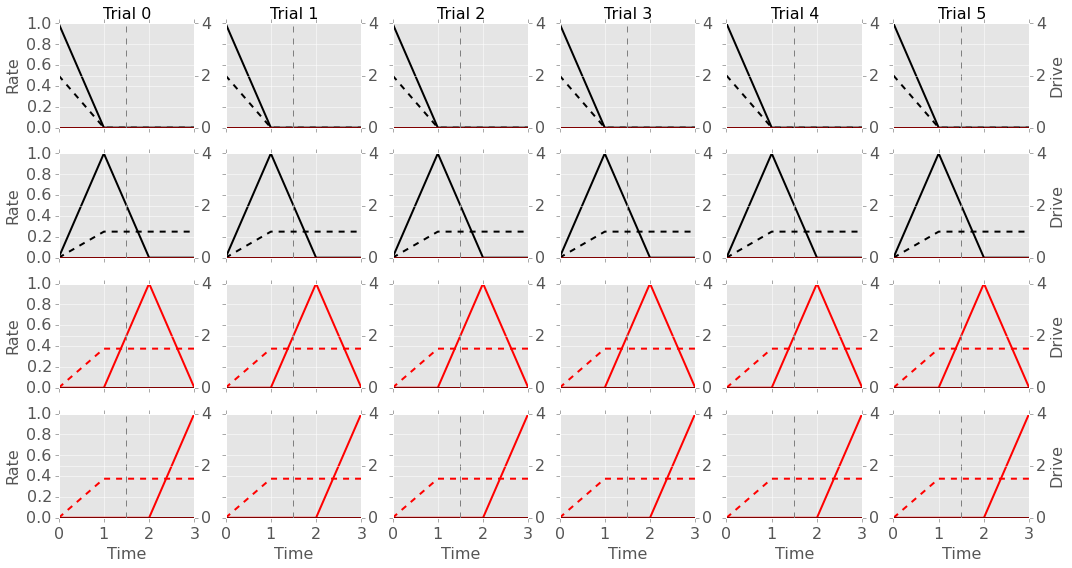

In [3]:
softmax_chains_planning_and_learning.planning(CONFIG)